# Tutorial 7: Belief Propagation for graph coloring

### Alessandro Lonardi and Caterina De Bacco

**Remark:** for the solution of points (2),(3),(4),(5) some of the parameters we propose in the solution are initialized to values allowing for the convergence to be reached fast. If you want to try some more expensive computations, use the values we suggest in the attached .pdf with the solution of the tutorial.

In [1]:
import networkx as nx
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

np.random.seed(67)

## Generate Erdős–Rényi graph

Here:
- ```N``` : number of nodes of the graph
- ```beta``` : "inverse temeprature" in the soft distribution
- ```q``` : number of colors
- ```c``` : average degree

In [3]:
N, beta, q, c = 100, 2, 3, 5
G = nx.erdos_renyi_graph(n=N, p=c/(N-1))
G = G.to_directed()

theta = 1 - np.exp(-beta)

Setting the convergence criteria:

$$\frac{1}{2 q M} \sum_{(i j) \in E} \sum_{s}\left|\left(\chi_{s}^{i \rightarrow(i j)}(t+1)-\chi_{s}^{i \rightarrow(i j)}(t)\right)\right|<\tilde{\epsilon}$$

In [8]:
# Checking the convergence
def convergence(el1, graph, abs_tol):
    #print(abs_tol)
    """
    Inputs:
        el1: dict, 
        graph: nx.DiGraph, 
        abs_tol: float, convergence threshold
    Returns:
        (err, err < abs_tol): tuple(float, bool), 
    """
    
    # el1 -> message_new
    # graph
    
    # MESSAGE -> graph.edges()[e]['message_t']
    # EDGE -> graph.edges()[e]
    err = 0
    for e in el1:
        #el1 = {key -> (0,1): value -> [prob]}
        err +=  np.sum(abs( graph.edges()[e]['message_t'] - el1[e]) )
    err /=  2*q*graph.number_of_edges()/2
    return(err, err < abs_tol)

## Implementing the BP update

We assing to each edge of the graph an attribute ```"message_t"``` representing a message. The main steps we need to implement are two:
1) the initialization. In particular:

    - we initialize the messages close to the fixed point we found using the theory
    - we initialize the messages at random
    - we initialize them fixed at a value
        
2) the update. It can be done:

    - in parallel, i.e. we compute the sum-product update for all the messages, and then we update them;
    - randomly, i.e. we compute the sum-product update for one messages, and then we update it. We iterate the pair of oprations: (1) sum-product, (2) message update, so that we can use the new information of messages to update the variables

**PS:** In (2) permute the edges at random before implementing the BP equations. <br/>
**Remark:** remember to normalize the messages after the initialization!

In [9]:
def BP(G, beta, q, init='perturb', update='parallel', max_it=1000, abs_tol=1e-4, alpha=0.1, report=False):
    
    # Initialization BP messages
    if init == 'perturb':
        for e in G.edges():
            G.edges()[e]['message_t'] = 1/q + np.random.uniform(low=-alpha/q, high=alpha/q, size=q)
            G.edges()[e]['message_t'] = G.edges()[e]['message_t']/np.sum(G.edges()[e]['message_t'])
    elif init == 'random':
        for e in G.edges():
            G.edges()[e]['message_t'] = np.random.uniform(low=0, high=1, size=q)
            G.edges()[e]['message_t'] = G.edges()[e]['message_t']/np.sum(G.edges()[e]['message_t'])
    elif init == 'first-color':
        for e in G.edges():
            G.edges()[e]['message_t'] = np.array([1]+[0]*(q-1))
        
    # Iterating
    conv, it = False, 0
    differences = []
    
    if update=='parallel':
        while not conv and it<max_it: # <- time iteration
            # UPDATE (IMPLEMENTATION)
            message_new = {}
            for e in G.edges():
                i = e[0]
                j = e[1]
                prod = np.ones(q)
                for k in G.neighbors(i):
                    if k!=j:
                        prod *= 1 - theta*G.edges()[(k,i)]['message_t']
                if len(list(G.neighbors(i)))>1: # <- sanity check
                    prod = prod / np.sum(prod)
                    message_new[e] = prod
            
            # CHECK FOR CONVERGENCE
            diff, conv = convergence(message_new, G, abs_tol)
            differences.append(diff)
            it+=1
            
            # OLD <- NEW
            for e in G.edges():
                try:
                    G.edges()[e]['message_t'] = message_new[e]
                except:
                    pass

    #elif update=='random':
    #    while not conv and it<max_it
    #        # FILL

    if report:
        print('Number of iterations: {0}'.format(it))
    
    return(it, differences)

## Point 2)

Number of iterations: 1000
Number of iterations: 0


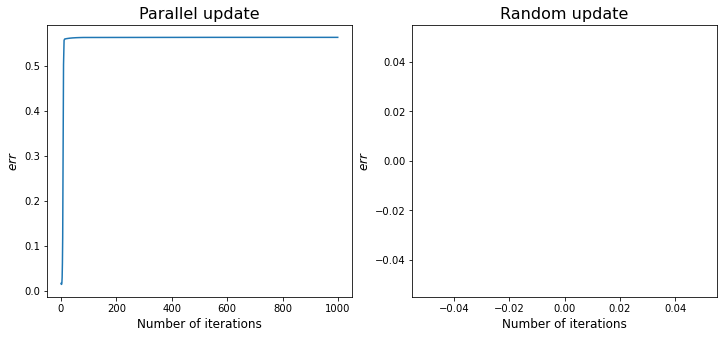

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

# Parallel update (all messages at once)
x, y = BP(G, beta, q, update='parallel', report=True)
ax[0].plot(np.arange(x), y)
ax[0].set_title('Parallel update', size=16)
ax[0].set_xlabel('Number of iterations',size=12)
ax[0].set_ylabel('$err$',size=12)

# Random update (one by one)
x, y = BP(G, beta, q, update='random', report=True)
ax[1].plot(np.arange(x), y)
ax[1].set_title('Random update', size=16)
ax[1].set_xlabel('Number of iterations', size=12)
ax[1].set_ylabel('$err$',size=12)

plt.savefig('tutorial10_point_b.png')
plt.show()

## Point 3)

In [ ]:
beta, q = 2, 3 # fixing beta and the colors
c_choices = np.linspace(0.1, 7, 10) # ranging the average degree
N_choices = [50] #, 100, 200] # ranging the number of nodes

result = np.zeros((len(c_choices),len(N_choices)+1))
result[:, 0] = c_choices
for j, N in enumerate(N_choices):
    #print("nodes:", N)
    for i, c in enumerate(c_choices):
        #print("degree:", c)
        iterations = []
        for _ in range(5): # computing the average over 5 executions
            G = nx.erdos_renyi_graph(n=N, p=c/(N-1))
            G = G.to_directed()        
            x, y = BP(G, beta, q)
            iterations.append(x)
        result[i, j+1] = np.median(iterations)

In [ ]:
plt.figure(figsize=(10,5))
for col in range(len(N_choices)):
    plt.plot(result[:,0], result[:,col+1], label='N = {0}'.format(N_choices[col]))
plt.legend(fontsize=12)
plt.xlabel('Average degree c', size=12)
plt.ylabel('Converge iteration', size=12)
plt.savefig('tutorial10_point_c.png')

## Point 4)

In [ ]:
# Attaching marginal distributions to each node
def marginals_one_point(G): # greedy choice of the label assignment, i.e. the label is the most probable
    for i in G.nodes():
        prod = np.ones(q)
        for k in G.neighbors(i):
            prod *= 1-theta*G.edges()[(k, i)]['message_t']
            prod /= np.sum(prod)
        G.nodes()[i]['marginal'] = prod
        
# Assessing the coloring mapping
def accuracy(G):
    errors = 0
    for e in G.edges():
        i = e[0]
        j = e[1]
        if np.argmax(G.nodes()[i]['marginal']) == np.argmax(G.nodes()[j]['marginal']):
            errors += 1 # violation of the game -> two neighboring nodes are assigned to the same value
    return(errors/2) # avoid double counting of edges

In [ ]:
beta, q = 2, 3 # fixing beta and the colors
c_choices = np.linspace(2, 7, 10) # ranging the average degree
result1 = np.zeros((len(c_choices),3))
result1[:, 0] = c_choices
N = 500 # fixing the number of nodes
for i, c in enumerate(c_choices):
    errors = []
    print("degree:", c)
    for _ in range(5):
        G = nx.erdos_renyi_graph(n=N, p=c/(N-1))
        G = G.to_directed()
        x, y = BP(G, beta, q)
        marginals_one_point(G)
        errors.append(accuracy(G)/(G.number_of_edges()/2))
    result1[i, 1] = np.mean(errors)
    result1[i, 2] = np.std(errors)

In [ ]:
plt.figure(figsize=(10,5))
plt.errorbar(result1[:,0], result1[:,1], result1[:,2])
plt.xlabel('Average degree c', size=12)
plt.ylabel('Fraction of violations', size=12)
plt.savefig('tutorial10_point_d.png')
plt.show()

## Point 5)

In [ ]:
N = 1000
q = 3
c = 5

G = nx.erdos_renyi_graph(n=N, p=c/(N-1))
G = G.to_directed()

plt.figure(figsize=(10,5))
for init in ['perturb','random','first-color']:
    print('\nInitialization {0}'.format(init))
    x, y = BP(G, beta, q, init=init, report=True)
    plt.plot(np.arange(x), y, label=init)
plt.legend(fontsize=12)
plt.xlabel('Number of iterations',size=12)
plt.ylabel('$err$', size=12)
plt.savefig('tutorial10_point_e.png')
plt.show()